# __SpringBoard Capstone Project 2: Human Activity Recognition__
## __Machine Learning__

__Written by: Sofy Weisenberg__<br>
__Date: 04/19/20__

__Importing the Data__<br>
Load the data from file into a pandas dataframe. The raw data has been pre-processed and the feature engineering has already been performed to create a processed dataset. See the project report for more details on those steps. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import time

# Use the current working directory path to navigate to the location of the processed data
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, '..', 'data', 'processed')

# Throw an assert error if the path does not exist
assert os.path.exists(data_path)

In [2]:
# Read the fully processed dataframe from file (df created and saved in Exploratory Data Analysis notebook)
full_data_df = pd.read_csv(os.path.join(data_path,'full_data_df.csv'))

__Initial Exploration__<br>
Now that the data has been loaded, the dataframe can be examined to gain a clearer picture of the data structure and features.

In [3]:
full_data_df.info()

# Throw an assert error if there are any missing values in the dataset
assert (full_data_df.isnull().sum().sum() == 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 44.2+ MB


In [4]:
# Display a few rows of the data
full_data_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


It can be seen that there are a total of 10299 rows and 563 columns, with no missing values. The feature data is all data type float64, and the last 2 columns are the subject number (int64) and the activity class (object).

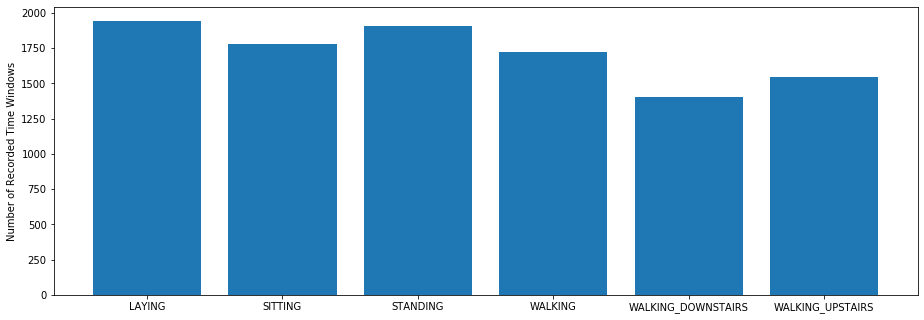

In [20]:
# plot the distribution of recorded time windows across various activities
counts = full_data_df.groupby('Activity').count().subject.values
activities = full_data_df.groupby('Activity').count().subject.index
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(activities, counts)
ax.set_ylabel('Number of Recorded Time Windows')
plt.show()

The various activity classes are approximately evenly distributed since each subject performed each of the six activities. This means that for classification modeling, this is a balanced (rather than an imbalanced) dataset.

Next, it would be helpful to see a summary of the descriptive statistics for the data. This is done using the .describe() method.

In [ ]:
full_data_df.describe()

In [74]:
# Check all columns for range [-1, 1]

def check_range(dataframe, range_min, range_max):
    columns = list(dataframe)
    max_false_count = 0
    min_false_count = 0
    
    # Loop over feature columns to check min, max (rounded to avoid float mismatches)
    for column in columns:
        if round(max(dataframe[column]),4) != range_max:
            max_false_count += 1
            print(f'Max value is not {range_max} for column: ' + str(column))
        if round(min(dataframe[column]),4) != range_min:
            min_false_count += 1
            print(f'Min value is not {range_min} for column: ' + str(column))
        
    # Throw an assert error if there are columns for which the range is not[range_min, range_max]
    assert (max_false_count == 0)        
    assert (min_false_count == 0)
    
    return

In [75]:
check_range(full_data_df.drop(['subject', 'Activity'], axis=1),-1,1)

From the results of the .describe() method and the two passing assert statements in the function defined above, it appears that the data has already been scaled to a range of [-1, 1] for all feature columns, which is helpful for both data visualization and machine learning to some extent. Additional scaling will need to be performed to make the data more usable for a supervised learning classification model (see section on Feature Scaling).

__Splitting the Data: Training and Test Sets__<br>
In order to allow for evaluation of the machine learning (ML) model, it is critical to split the full data set into a training set (used to train the ML model) and a test set (used to evaluate the model's performance). 

In this case, a stratified split is important (i.e. making sure that the classes are represented in both the training and test sets relatively equally). Also, it must be taken into account that entire activities and subject sets should be kept together. Movement patterns of the same subject should be segregated so as not to bias the test set. 

Therefore of the 30 participating subjects' data, 30% (9 subjects) will be segregated into the test set and saved for the evaluation phase. These subjects have been selected randomly (Kaggle has already provided the data in train/test split for this dataset.)

***Question***: Should the training be rerun after evaluation on the entire data set so that all samples may be utilized for training?

In [31]:
# read train/test data from file
train_data_df = pd.read_csv(os.path.join(data_path,'train.csv'))
test_data_df = pd.read_csv(os.path.join(data_path,'test.csv'))

# define train/test feature matrices (X) and class label vectors (y)
X_train = train_data_df.drop(['Activity', 'subject'], axis=1)
X_test = test_data_df.drop(['Activity', 'subject'], axis=1)
y_train = train_data_df['Activity']
y_test = test_data_df['Activity']
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(7352, 561) (2947, 561)
(7352,) (2947,)


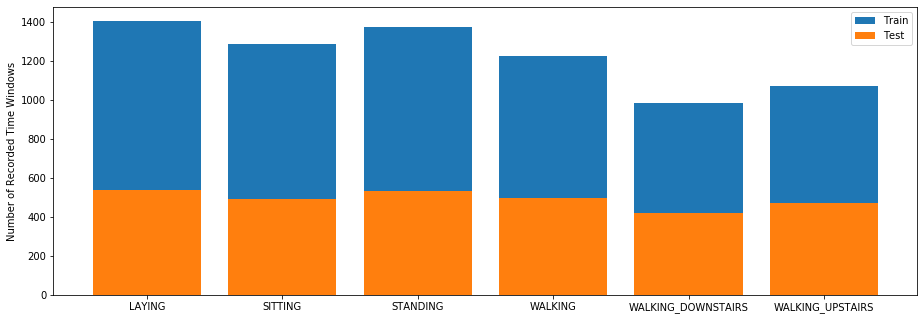

In [39]:
# check activity distribution between train and test sets
activities = train_data_df.groupby('Activity').count().subject.index
train_counts = train_data_df.groupby('Activity').count().subject.values
test_counts = test_data_df.groupby('Activity').count().subject.values
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(activities, train_counts, label='Train')
ax.bar(activities, test_counts, label='Test')
ax.set_ylabel('Number of Recorded Time Windows')
ax.legend(loc='upper right')
plt.show()

__Feature Scaling__<br>
To improve performance of the machine learning model(s) to be applied to this classification problem, first the feature data should be appropriately scaled.

Scaling must be performed both on the training and test data sets in the same manner. Best practice is to use only the training set to identify the correct scaling, and then blindly apply the same transformation to the test set. In this case, scaling all features to a [0,1] range is a common scaling method for neural network preprocessing and will be applied using the MinMaxScaler() transformation method from sklearn.

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# check successful feature scaling across all feature data sets using function defined in initial exploration
check_range(pd.DataFrame(X_train_scaled),0,1)

The scaling transformation has been performed successfully on both the training and test feature sets. <br>
- The range for each column in the X_train_scaled feature matrix is [0,1] <br>
- The range for each column in the X_test_scaled feature matrix is different than [0,1], since a transformation matrix (generated from normalizing the training feature matrix range) was applied to the test feature matrix.

__Categorical Class Encoding__<br>
Since the class labels (Activity column) for this data are in a categorical string format, they must first be encoded to a numerical format useable for supervised machine learning. Simple integer encoding (i.e. translating each class label into an integer label 1-6) would not be effective on its own in this case, since such an encoding implies an ordinal relationship between the classes, where in reality there is none. This may result in poor model performance or unexpected results.

Integer encoding followed by one-hot encoding is the preferred method to transform the categorical data. Each integer class label is assigned to a new binary (0/1) column of "dummy variables". Each observation in the dataset is then be labeled with a 1 in only one of these "dummy variable" columns and the rest are labeled with a 0. 

__Visualizing Misclassified Activities__<br>
To better understand the limitations of the RNN model, it is helpful to visualize some of the signal data from activity instances that were misclassified by the model.